<a href="https://colab.research.google.com/github/prathamsss/Car-Damage-Project/blob/master/CarDamage_classification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
plt.ion()
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
#import torch.utils.data as data
#from torch.utils.data import Dataset
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import os
%matplotlib inline
#mounting google drive to access the dataset from drive folder
from google.colab import drive
drive.mount('/content/drive')
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from functools import partial
from threading import Thread
from tornado import gen
plt.ion() 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
cd /content/drive/My Drive/ML/dataease_internship

/content/drive/My Drive/ML/dataease_internship


In [ ]:
"""import os
os.environ['KAGGLE_USERNAME'] = "pratham2307"

os.environ['KAGGLE_KEY'] = "97f467d91f0532c14b98141d6e817386"

!kaggle datasets download -d anujms/car-damage-detection
!unzip car-damage-detection.zip
"""  # On this to download data

In [75]:
def get_data_loaders(data_dir, batch_size):
  
  transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
  

  all_data = datasets.ImageFolder(data_dir, transform=transform)

  train_data_len = int(len(all_data)*0.70)
  valid_data_len = int((len(all_data) - train_data_len))
  train_data, val_data = random_split(all_data, [train_data_len, valid_data_len])
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
  dataset_sizes = {x: len(x) for x in [train_data, val_data]}

  return train_loader, val_loader, all_data.classes, dataset_sizes

In [178]:
train, val, classes, dataset_sizes  = get_data_loaders("/content/drive/My Drive/ML/dataease_internship/data1a/train", 64)
dataset_sizes = {'train':1610,'val':690}


2300 1610 690


In [179]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([64, 3, 224, 224]) torch.Size([64])


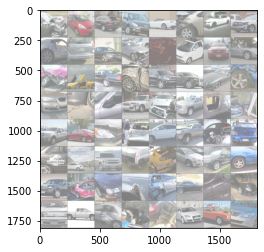

00-damage 01-whole 00-damage 01-whole


In [180]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(dataloaders['train'])       # GIve input
images, labels = dataiter.next()
print(images.shape,labels.shape)
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))  #Labels

In [84]:
loss_train=[]
epo=[]
loss_val=[]
acc_train=[]
acc_val=[]
v_epo=[]
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            


            if phase=='train':
              loss_train.append(epoch_loss)
              epo.append(epoch)
              acc_train.append(epoch_acc)

            if phase=='val':
              loss_val.append(epoch_loss)
              v_epo.append(epoch)
              acc_val.append(epoch_acc)  
            
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [99]:
from matplotlib.pyplot import figure

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    figsize=(20,40)
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [127]:
from torch.utils.tensorboard import SummaryWriter

model_nm= 'resnet18'
learning_rate =0.0001 
momentum=0.9
no_classes= 2

model_conv = torchvision.models.resnet18(pretrained=True)  # load pretrained model
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, no_classes)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=learning_rate, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [87]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.6836 Acc: 0.5919
val Loss: 0.6281 Acc: 0.6449

Epoch 1/19
----------
train Loss: 0.5779 Acc: 0.7025
val Loss: 0.5598 Acc: 0.7029

Epoch 2/19
----------
train Loss: 0.5082 Acc: 0.7957
val Loss: 0.4843 Acc: 0.8043

Epoch 3/19
----------
train Loss: 0.4602 Acc: 0.8323
val Loss: 0.4505 Acc: 0.8101

Epoch 4/19
----------
train Loss: 0.4253 Acc: 0.8478
val Loss: 0.4228 Acc: 0.8304

Epoch 5/19
----------
train Loss: 0.4008 Acc: 0.8584
val Loss: 0.3938 Acc: 0.8580

Epoch 6/19
----------
train Loss: 0.3756 Acc: 0.8714
val Loss: 0.3737 Acc: 0.8638

Epoch 7/19
----------
train Loss: 0.3681 Acc: 0.8602
val Loss: 0.3726 Acc: 0.8594

Epoch 8/19
----------
train Loss: 0.3679 Acc: 0.8702
val Loss: 0.3742 Acc: 0.8594

Epoch 9/19
----------
train Loss: 0.3603 Acc: 0.8783
val Loss: 0.3737 Acc: 0.8580

Epoch 10/19
----------
train Loss: 0.3634 Acc: 0.8745
val Loss: 0.3788 Acc: 0.8522

Epoch 11/19
----------
train Loss: 0.3616 Acc: 0.8714
val Loss: 0.3692 Acc: 0.8594

Ep

train =  [0.6836266579835312, 0.5779041228827483, 0.5081639122888909, 0.46021850275697174, 0.42534248958463255, 0.40080480368241017, 0.37560270661893097, 0.36810287485211535, 0.36789942702151235, 0.3602689318405175, 0.36342953125142163, 0.3616038827052028, 0.36061081308755816, 0.3603883829916486, 0.35824928043051535, 0.35975266280381574, 0.3625356906319257, 0.3585709431526824, 0.35650034683831733, 0.35745742546845666] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] [tensor(0.5919, device='cuda:0', dtype=torch.float64), tensor(0.7025, device='cuda:0', dtype=torch.float64), tensor(0.7957, device='cuda:0', dtype=torch.float64), tensor(0.8323, device='cuda:0', dtype=torch.float64), tensor(0.8478, device='cuda:0', dtype=torch.float64), tensor(0.8584, device='cuda:0', dtype=torch.float64), tensor(0.8714, device='cuda:0', dtype=torch.float64), tensor(0.8602, device='cuda:0', dtype=torch.float64), tensor(0.8702, device='cuda:0', dtype=torch.float64), tensor(0.8783, devic

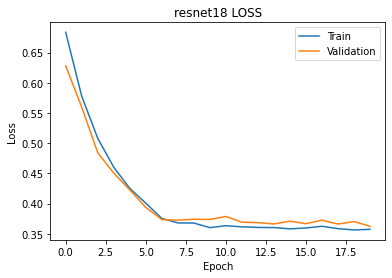

In [191]:
print('train = ',loss_train, epo, acc_train,'\nval= ',loss_val, v_epo, acc_val)
import matplotlib.image as mpimg

torch.save(model_conv, "/content/drive/My Drive/ML/dataease_internship/Output_Data_Details/model_best_resnet_18.pth")
plt.plot(epo, loss_train,label='Train') 
plt.plot(v_epo, loss_val, label = 'Validation')   

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(model_nm+" LOSS")

plt.legend()
plt.savefig("/content/drive/My Drive/ML/dataease_internship/Output_Data_Details/Torch_Resnet18.jpg",bbox_inches='tight')


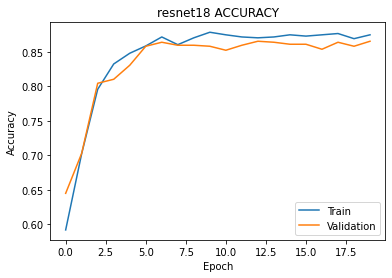

In [192]:
plt.plot(epo, acc_train,label='Train') 
plt.plot(v_epo, acc_val, label = 'Validation')   

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(model_nm+" ACCURACY")

plt.legend()

plt.savefig("/content/drive/My Drive/ML/dataease_internship/Output_Data_Details/Torch_Resnet18_Accuracy.jpeg")

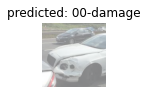

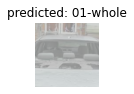

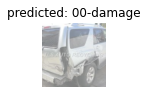

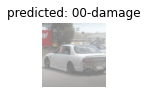

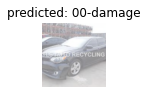

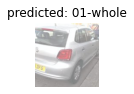

In [100]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [101]:
#print(confusion_matrix.diag()/confusion_matrix.sum(1))   # Acuuracy per class 
from sklearn.metrics import confusion_matrix

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[321  52]
 [ 41 276]]
[86.05898123 87.06624606]


In [102]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

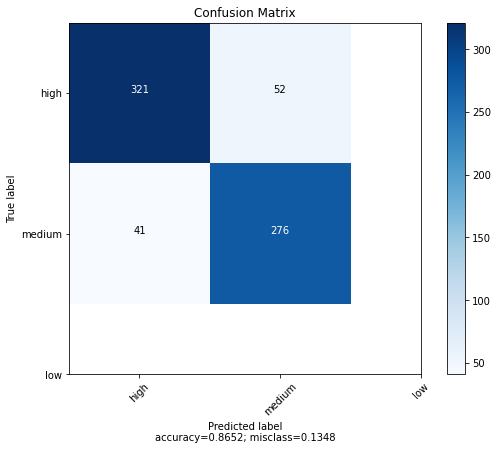

In [103]:
plot_confusion_matrix(cm = conf_mat, 
                      normalize    = False,
                      target_names = ['high', 'medium', 'low'],
                      title        = "Confusion Matrix")


In [113]:
from sklearn import metrics
print(metrics.classification_report(lbllist, predlist,target_names=classes))

              precision    recall  f1-score   support

   00-damage       0.89      0.86      0.87       373
    01-whole       0.84      0.87      0.86       317

    accuracy                           0.87       690
   macro avg       0.86      0.87      0.86       690
weighted avg       0.87      0.87      0.87       690



In [173]:
# On this cell to save model details
"""
data = {'model      :  ':model_nm,'learning_rate    :   ':learning_rate,
        'momentum    :   ': momentum,'no_classes     :  ': no_classes,
        'Avg Traning Accuracy  : ':sum(acc_train)/len(acc_train),
        'AvgValidatio Accuracy  : ':  sum(acc_val)/len(acc_val),

        'class_accuracy  :   ':class_accuracy}

import pickle as pickle

with open('Data.txt', 'a') as f:
    for key, value in data.items():
      d=key,value
      f.write('\n')
      f.write(str(d)+"\n")
      f.write('\n')

"""

In [167]:
sum(acc_train)/len(acc_train)

tensor(0.8419, device='cuda:0', dtype=torch.float64)

In [174]:
!wget 

/content


drive/  sample_data/
